# HW 3 - Image Segmentation and Sentiment Analysis

## Part A: Image Segmentation

You get 20 points for setting up AWS and successfully running the code given in this part.

# What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

# Prerequisites

This homework needs to be run on an AWS GPU instance; it will not complete in time without a GPU. Look up the relevant documentation to set up an AWS machine as configured below; the same machine may be "stopped" (not "terminated") and then resumed for use in the final exam.

**Machine.**

   - Use the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Use a p2.xlarge instance.
   - Allocate at least 80GB of disk space.
   - Use the `conda_tensorflow_p36` Conda environment: `source activate tensorflow_p36`
   - Create a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: `pip install cython`
   * Install Tensorflow: `pip install tensorflow==1.3.0 tensorflow-gpu==1.3.0`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4362681768260872270
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3015298456504977925
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14102519478366416543
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7855604847572813028
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

Make sure you understand the annotations and how they are connect to images by looking at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

## Set up the environment

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print(IMAGE_DIR)

Using TensorFlow backend.


/home/ubuntu/HW3/logs
/home/ubuntu/HW3/mask_rcnn_coco.h5
/home/ubuntu/HW3/images


## Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

## Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [4]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 8.21 s, sys: 512 ms, total: 8.72 s
Wall time: 9.97 s


## Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Load and visualize a random image

Make sure you understand what the code below is doing.

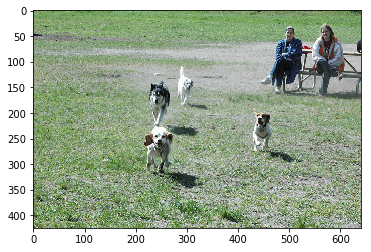

In [6]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

## Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 3.13 s, sys: 788 ms, total: 3.92 s
Wall time: 5.27 s


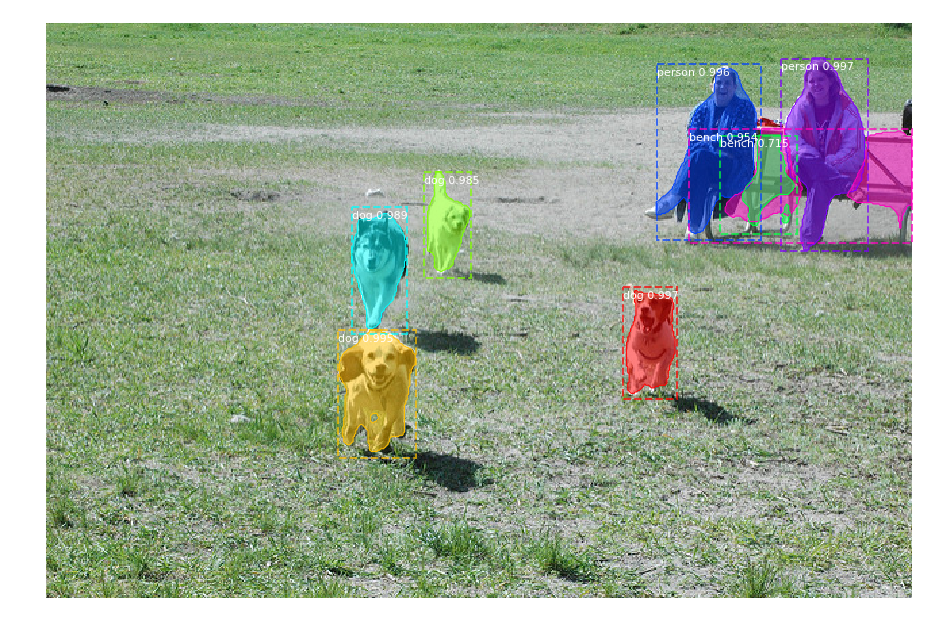

In [7]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

## Load the data

Load the annotations for the training images into memory.

In [8]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
CPU times: user 800 ms, sys: 52 ms, total: 852 ms
Wall time: 939 ms


Now load the same for the test images.

In [9]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=5.38s)
creating index...
index created!
CPU times: user 6.21 s, sys: 372 ms, total: 6.58 s
Wall time: 7.19 s


## List a few object classes

In [10]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


## Visualize a random image and its annotations

image_id  4188 http://cocodataset.org/#explore?id=105264
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (427, 640, 9)         min:    0.00000  max:    1.00000
class_ids                shape: (9,)                  min:    1.00000  max:   20.00000
bbox                     shape: (9, 4)                min:    0.00000  max:  575.00000


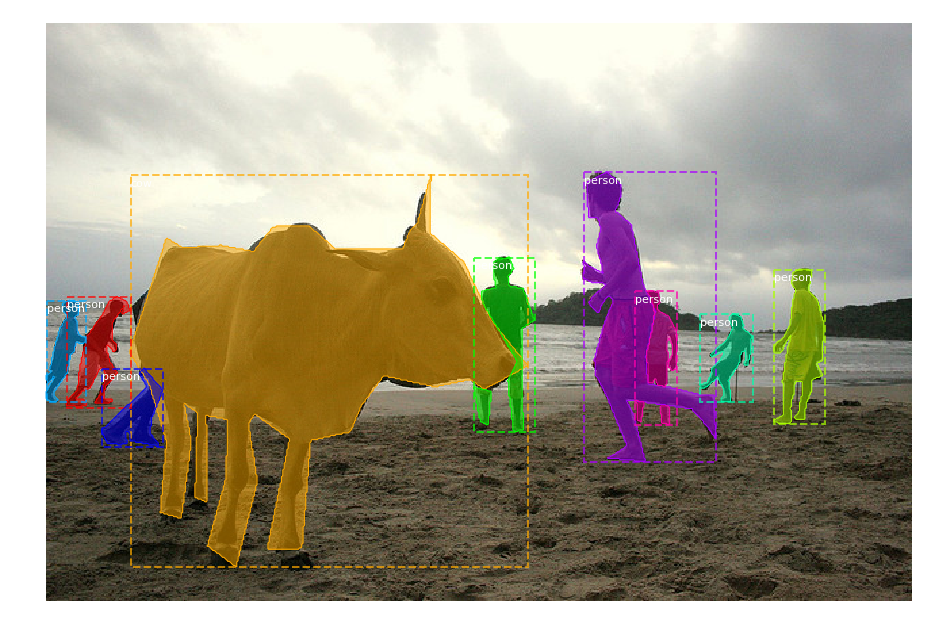

In [11]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Training configuration

See the default configuration values in `config.py`.

In [12]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

## Create a new model in training mode [5 points]

In [13]:
# Create model in training mode
model = %%time
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


## Initialize the model weights with the weights learned on COCO [5 points]

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [14]:
# your code here
model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"])

## Train the model for 10 epochs [5 points]

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [15]:
%%time
# call to train
model.train(dataset, dataset_val, layers="heads", learning_rate=config.LEARNING_RATE,epochs=10)


Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/HW3/logs/coco20180501T1713/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 1/10


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


60/60 [==============================] - 68s 1s/step - loss: 3.5460 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.3178 - mrcnn_class_loss: 1.5587 - mrcnn_bbox_loss: 0.8705 - mrcnn_mask_loss: 0.7789 - val_loss: 1.7749 - val_rpn_class_loss: 7.2134e-04 - val_rpn_bbox_loss: 0.0412 - val_mrcnn_class_loss: 0.5526 - val_mrcnn_bbox_loss: 0.5208 - val_mrcnn_mask_loss: 0.6596
Epoch 2/10
60/60 [==============================] - 55s 923ms/step - loss: 2.5043 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3568 - mrcnn_class_loss: 0.9111 - mrcnn_bbox_loss: 0.6221 - mrcnn_mask_loss: 0.5988 - val_loss: 1.1783 - val_rpn_class_loss: 6.0222e-04 - val_rpn_bbox_loss: 0.0916 - val_mrcnn_class_loss: 0.2326 - val_mrcnn_bbox_loss: 0.3788 - val_mrcnn_mask_loss: 0.4747
Epoch 3/10
60/60 [==============================] - 56s 931ms/step - loss: 2.2054 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.3864 - mrcnn_class_loss: 0.7248 - mrcnn_bbox_loss: 0.5494 - mrcnn_mask_loss: 0.5244 - val_loss: 1.2349 - val_rpn_class_loss: 0

## Visualize learning progress with TensorBoard [5 points]

   - Start Tensorboard with `tensorboard --logdir=logs/` in the same folder as the notebook:
```
TensorBoard 0.1.8 at http://ip-172-31-27-18:6006 (Press CTRL+C to quit)
```

   - Connect to `public_dns:6006` where `public_dns` is your public DNS.
   - Click on the "Scalars" tab at the top of the page.
   - Include a screenshot of the overall loss vs. number of epochs below this line (store the image in the same folder as the notebook as "yourloss.png".
   
 <img src="yourloss.png"/>

## Test model [10 points]

Load the model in inference (testing) mode.

In [20]:
# load model
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

Load the last trained model weights.

In [21]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    1.00000  max: 24813.00000
gt_class_id              shape: (8, 4)                min:  155.00000  max:  864.00000
gt_bbox                  shape: (8, 4)                min:  155.00000  max:  864.00000
gt_mask                  shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000


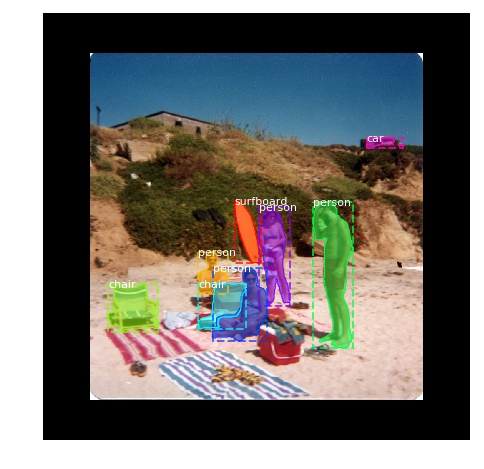

In [22]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


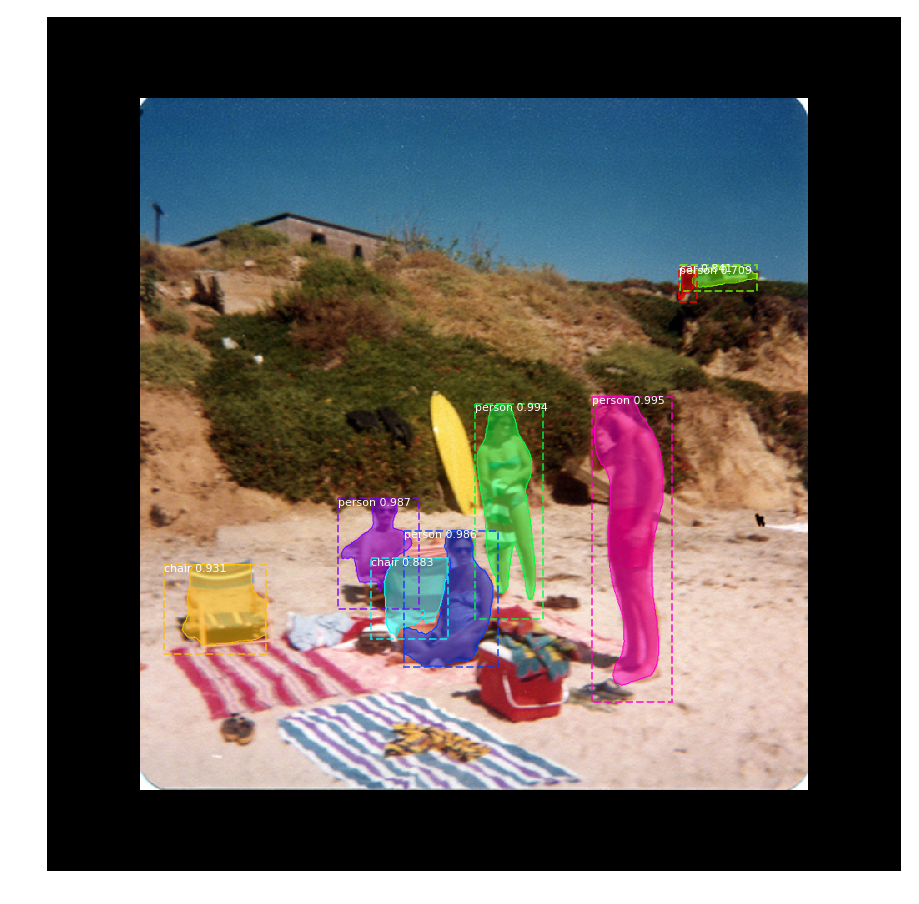

In [23]:
# prediction function call and visualization
vals = model.detect([original_image], verbose=1)
r = vals[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

## Part B: Sentiment Analysis

Download data from: https://www.dropbox.com/s/ouhiwmzodc4baob/HW3-data-Sentiment.zip?dl=0 <br>

The folder contains:

- Train.csv
- test.csv

### 1. Read the training data  [5 Points]

Read the data present in training.csv file. **Please do no change the file name and use relative path, i.e. './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the Sentiment and sentiment text in the dataframe - the first and the last coumn
2. Some of the sentiments and sentiment texts are empty. Remove those rows.
3. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
4. Print the first 5 sentiments.
5. Print the number of positive and negative sentiments

In [24]:
# your code here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
df = pd.read_csv("./HW3-data/train.csv", sep=",", encoding="latin-1", header=None)
df_main = df[[0,5]]
df1 = df_main.dropna(axis=0, how='any')
df3 = df1.sample(frac=1)
df3[:5]


,0,5
368,0,Wow. The most depressing thing in the world is...
1558442,1,"A woman and her daughter at the pet store, who..."
8858,0,Is alone.
209698,0,"@Djalfy To me Kanye West WAS sexy,lately tho h..."
1511436,1,@AnnyChih They have a wildlife exhibit at Drea...


In [25]:
neg = 0
pos = 0
for val in df3[0]:
    if(val==0):
        neg += 1 
    if(val==1):
        pos += 1
        
print("Number of negative sentiments: ",neg)
print("Number of positive sentiments: ",pos)

Number of negative sentiments:  800000
Number of positive sentiments:  800000


### 2. Data Preparation [10 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (twitters), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the dataframe, and convert them to a list of strings, where each string is a tweet. [1 pt]

In [26]:
# your code here
list_str = list(df3.iloc[:5000,1])
labels = list(df3.iloc[:5000,0])

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [27]:
# your code here
from keras.preprocessing.text import Tokenizer
token =Tokenizer(num_words=10000,lower=True,split=" ",char_level=False,oov_token=None)
token.fit_on_texts(list_str)
token_seq = token.texts_to_sequences(list_str)

3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [28]:
# your code here
from keras import preprocessing
pad_seq = preprocessing.sequence.pad_sequences(token_seq, maxlen=120, value=0)

4\. Split the above data (the sequence and the label) into training (67%) and validation (33%) sets. [3 pts]

In [29]:
# your code here
from sklearn.model_selection import train_test_split
X_train, X_Valid, Y_train, Y_Valid = train_test_split(pad_seq, labels, test_size=0.33, shuffle=True)

### 3. RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [30]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
model = Sequential()
model.add(Embedding(10000,64))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [31]:
# your code here
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

2\. Fit the model with the training set with 5 epochs and batch size 32.

In [38]:
# your code here
fit_info = model.fit(X_train, Y_train,
                    epochs=5,
                    batch_size=32,
                   validation_data=(X_Valid,Y_Valid))

Train on 3350 samples, validate on 1650 samples
Epoch 1/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.6755 - acc: 0.5851 - val_loss: 0.6587 - val_acc: 0.5885
Epoch 2/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.5175 - acc: 0.7576 - val_loss: 0.6775 - val_acc: 0.6352
Epoch 3/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.3651 - acc: 0.8501 - val_loss: 0.6753 - val_acc: 0.6794
Epoch 4/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.2690 - acc: 0.8899 - val_loss: 0.6631 - val_acc: 0.6909
Epoch 5/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.2039 - acc: 0.9245 - val_loss: 0.7222 - val_acc: 0.6915


3\. Plot the training and validation accuracy for each epoch.

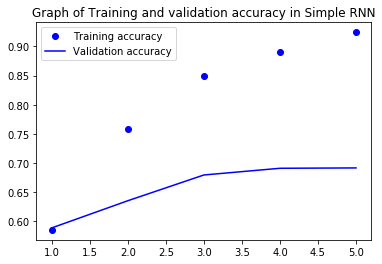

In [39]:
# your code here
ac = fit_info.history['acc']
val_ac = fit_info.history['val_acc']
epochs = range(1, len(ac) + 1)
plt.plot(epochs, ac, 'bo', label='Training accuracy')
plt.plot(epochs, val_ac, 'b', label='Validation accuracy')
plt.title('Graph of Training and validation accuracy in Simple RNN')
plt.legend()
plt.show()

### 4. LSTM [10 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [34]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(10000,64))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy for each epoch.

Train on 3350 samples, validate on 1650 samples
Epoch 1/5
3350/3350 [==============================] - 24s 7ms/step - loss: 0.6626 - acc: 0.5994 - val_loss: 0.5961 - val_acc: 0.6873
Epoch 2/5
3350/3350 [==============================] - 21s 6ms/step - loss: 0.5071 - acc: 0.7743 - val_loss: 0.5576 - val_acc: 0.7139
Epoch 3/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.3935 - acc: 0.8394 - val_loss: 0.5709 - val_acc: 0.7327
Epoch 4/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.3028 - acc: 0.8851 - val_loss: 0.6082 - val_acc: 0.7248
Epoch 5/5
3350/3350 [==============================] - 20s 6ms/step - loss: 0.2373 - acc: 0.9131 - val_loss: 0.6188 - val_acc: 0.7109


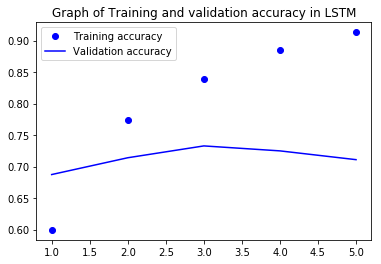

In [35]:
# your code here
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

fit_info_lstm = model.fit(X_train, Y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_Valid,Y_Valid))

acc = fit_info_lstm.history['acc']
val_acc = fit_info_lstm.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Graph of Training and validation accuracy in LSTM')
plt.legend()
plt.show()

iii) [6 points] In the previous models, we only use the top 5000 tweets. Now use the whole dataset, split it into training (67%) and validation (33%) set, and train the same LSTM model on the new traning data. plot the training and validation accuracy for each epoch.

Train on 1072000 samples, validate on 528000 samples
Epoch 1/5
1072000/1072000 [==============================] - 290s 271us/step - loss: 0.4285 - acc: 0.8007 - val_loss: 0.4057 - val_acc: 0.8148
Epoch 2/5
1072000/1072000 [==============================] - 290s 271us/step - loss: 0.3955 - acc: 0.8200 - val_loss: 0.3947 - val_acc: 0.8209
Epoch 3/5
1072000/1072000 [==============================] - 289s 270us/step - loss: 0.3847 - acc: 0.8258 - val_loss: 0.3910 - val_acc: 0.8228
Epoch 4/5
1072000/1072000 [==============================] - 289s 270us/step - loss: 0.3770 - acc: 0.8303 - val_loss: 0.3881 - val_acc: 0.8247
Epoch 5/5
1072000/1072000 [==============================] - 290s 270us/step - loss: 0.3704 - acc: 0.8338 - val_loss: 0.3871 - val_acc: 0.8249


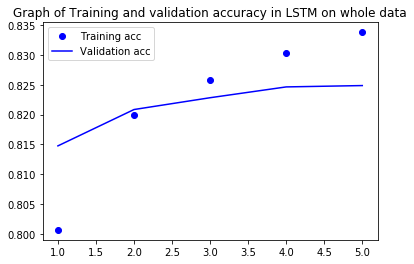

In [37]:
# your code here
col1 = df3.columns[1]
col0 = df3.columns[0]
list_total = list(df3[col1])
label_total = list(df3[col0])

token.fit_on_texts(list_total)
token_seq_total = token.texts_to_sequences(list_total)
pad_seq_total = preprocessing.sequence.pad_sequences(token_seq_total, maxlen=120, value=0)


history = model.fit(pad_seq_total, np.array(label_total),
                    epochs=5,
                    batch_size=1000,
                    validation_split=.33)



acc = history.history['acc']
val_acc = history.history['val_acc'] 
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Graph of Training and validation accuracy in LSTM on whole data')
plt.legend()
plt.show()

### 4. Results Comparision [5 points]

1\. [2 points] Compare the simple RNN model and the LSTM model (trained on the 5000 tweets sample). Which one has a better performance? Why does this one outperform the other one?

(your answer here)

2\. [3 points] Compare the LSTM model trained on a 5000 tweets sample and the one trained on the whole dataset. What are the cost and the benefit of each case?

(your answer here)